In [1]:
import json
import pandas as pd
from mt_utils import *
from datetime import datetime
from datetime import timedelta
from datetime import time
import requests
from functools import reduce
import numpy as np

REQUEST_MARKER = '_'
#OPTION_PRICE_COL = 'close'
OPTION_PRICE_COL = 'mid'



option_urls = [
    "https://www.dropbox.com/s/ahlb9ldhnmemmwn/option_bars.json?dl=1"
]

underlying_urls = [
    "https://www.dropbox.com/s/ll8xa6xb1xhrhv7/underlying_bars.json?dl=1"
]


In [2]:
def download(url):
    r = requests.get(url)
    return r.content


actions = json.loads(download("https://www.dropbox.com/s/psgut932tw77b82/actions.json?dl=1"))
print(actions[0])


def download_data(urls):
    data = []
    for url in urls:
        print(url)
        data.extend(json.loads(download(url)))
    return mt_dict_to_df(data)

options_cache = download_data(option_urls)
    
print('options_cache:',len(options_cache))

if len(options_cache):

    options_cache['time'] = options_cache['time'].dt.to_pydatetime()
    options_cache['expiry'] = options_cache['expiry'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d %H:%M:%S').date())    
    options_cache['symbol'] = options_cache['symbol'].apply(lambda x: x.split()[0])
    
    
    print("sorting options_cache")
    options_cache.sort_values(by=['symbol','type','strike','expiry','time'],inplace=True)
    print("finished")
    options_cache.drop_duplicates(inplace=True)
    print("after drop",len(options_cache))
    
    

underlying_cache = download_data(underlying_urls)

print('underlying_cache:',len(underlying_cache))

if len(underlying_cache):
    underlying_cache['time'] = underlying_cache['time'].apply(lambda x: x.to_pydatetime())
    
    print('sorting underlying_cache')
    underlying_cache.sort_values(by=['symbol','time'],inplace=True)
    print('finished')
    underlying_cache.drop_duplicates(inplace=True)
    print("after drop:",len(underlying_cache))
    

{'ts': '2020-05-26T06:52:24', 'action': 'shorting', 'sym': 'ZM', 'spread_type': 'CALL', 'strike_date': '2020-05-29', 'strikes': [180.0, 185.0]}
https://www.dropbox.com/s/ahlb9ldhnmemmwn/option_bars.json?dl=1
options_cache: 865075
sorting options_cache
finished
after drop 865056
https://www.dropbox.com/s/ll8xa6xb1xhrhv7/underlying_bars.json?dl=1
underlying_cache: 417290
sorting underlying_cache
finished
after drop: 417290


In [18]:
def search_underlying_cache(sym,start_time,end_time):
    
    if not len(underlying_cache):
        return pd.DataFrame(),0
    
    sym = sym + REQUEST_MARKER
    
    df = underlying_cache[ (underlying_cache['symbol'] == sym) &
                        (underlying_cache['time'] >= start_time) &
                       (underlying_cache['time'] <= end_time)]
    
    return df

def search_options_cache(sym,expiry,strike,spread_type,ts_start,ts_end):

    
    if not len(options_cache):
        print("search_options_cache",sym,strike,spread_type,"NOT FOUND IN CACHE")
        return pd.DataFrame(),0
    
    sym = sym + REQUEST_MARKER
    
    df = options_cache[ (options_cache['symbol'] == sym)  &
                    (options_cache['type'] == ('Call' if spread_type == 'CALL' else 'Put'))  &
                    (options_cache['strike'] == strike)    &
                    (options_cache['expiry'] == expiry)   &
                    (options_cache['time'] >= ts_start)  &
                    (options_cache['time'] <= ts_end) ]
    
    return df


In [31]:
class Date_Reduce():
    date = None
    repeat = 0
    count = 0
    def __init__(self,repeat = 10):
        self.repeat = repeat
        
    def reduce(self,new_date):
        
        if self.date == None or self.count == self.repeat:
            self.date = new_date
            self.count = 0
            return str(new_date)
        
        if self.date.year != new_date.year:
            self.date = new_date
            self.count = 0
            return str(new_date)
        
        self.count = self.count + 1
        
        return " " * 5 + "{:02d}-{:02d}".format(self.date.month,self.date.day)
    
class Date_Time_Reduce(Date_Reduce):
    def __init__(self):
        super().__init__()
    def reduce(self,new_date_time):
        date_str = super().reduce(new_date_time.date())
        return date_str + " " + str(new_date_time.time())
    
class Premium_only():
    column_title = 'premium'
    pnl = 0
    events = 0
    spread_sum = 0
    def trade(self,trade):
        self.events = self.events + 1
        self.spread_sum = self.spread_sum + abs(trade.order.strike_sell - trade.order.strike_buy)
        premium = trade.price_sell - trade.price_buy
        self.pnl = self.pnl + premium
        return premium
    def summary_results(self):
        return "Strategy Premium only: trades = {} average premium to strike_spread = {}".format(self.events,round(self.spread_sum/self.pnl,2))
        
class Strategy_let_expire():
    name = 'expire'
    events_trade = 0
    events_breach = 0
    pnl = 0
    column_title = "expire"
    
    def trade(self,trade):
        if trade.order.spread_type == 'CALL':
            expire_value = calc_expire_result(trade.order.strike_buy,trade.order.strike_sell,trade.price_underlying_close,trade.price_underlying_close <= order.strike_sell,trade.price_underlying_close <= order.strike_buy)
        else:
            expire_value = -calc_expire_result(trade.order.strike_buy,trade.order.strike_sell,trade.price_underlying_close,trade.price_underlying_close >= order.strike_sell,trade.price_underlying_close >= order.strike_buy)
            
        if expire_value:
            self.events_breach = self.events_breach + 1
            self.pnl = self.pnl + expire_value
            
        self.events_trade = self.events_trade + 1
        
        return expire_value
    
    def description(self):
        return "Hold trade till expiration."
    
    def summary_results(self):
        return "Strategy Let Expire summary. trades: {}  breaches: {}  breach ratio: {} ".format(self.events_trade, self.events_breach, round(self.events_breach/(self.events_trade),3))
    
class Strategy_nx_premium():
    multiple = None
    pnl = 0
    column_title = "2xPrem"
    def __init__(self,multiple):
        self.multiple = multiple
        
    def trade(self,trade):
        
        premium = trade.price_sell - trade.price_buy
        
        minute_count = 0
        for x,row in trade.bars_premium.iterrows():
            cost_to_close = row['mid']
            if cost_to_close >= (premium * self.multiple):
                minute_count = minute_count + 1
                if minute_count >= 30:
                    self.pnl = self.pnl - cost_to_close
                    print("strategy 2xPrem closing",row['time'],cost_to_close)
                    return -cost_to_close
            else:
                minute_count = 0
                
        return
        
    
    def description(self):
        return ("Close trade when cost to close is twice premium received")
    
    def summary_results(self):
        return ""
    

        
    
    
    
class Order():
    ts_start = None
    symbol = None
    expiry = None
    spread_type = None
    strike_sell = None
    strike_buy = None
    
    dr = Date_Reduce()

    def __init__(self,ts,sym,spread_type,strike_date,strikes):
        #print('order:',ts,sym,spread_type,strike_date,strikes)
        self.ts_start = ts
        self.symbol = sym
        self.expiry = datetime.strptime(strike_date, '%Y-%m-%d') + timedelta(hours=16)
        self.spread_type = spread_type
        
        if spread_type == 'CALL':
            self.strike_sell = min(strikes)
            self.strike_buy = max(strikes)
        if spread_type == 'PUT':
            self.strike_sell = max(strikes)
            self.strike_buy = min(strikes)
            
    def __repr__(self):
        return "{:<8} {:<10} {:<4} {:6.1f}/{:6.1f}".format(self.symbol,self.dr.reduce(self.expiry.date()),self.spread_type,self.strike_sell,self.strike_buy)
            
class Trade():
    order = None
    bars_underlying = None
    bars_sell = None
    bars_buy = None
    bars_premium = None
    
    price_sell = None
    price_buy = None
    price_underlying_close = None
    
    
    def __init__(self,order):
        
        self.order = order
        self.bars_underlying = search_underlying_cache(order.symbol,order.ts_start,order.expiry)
        self.bars_sell = search_options_cache(order.symbol,order.expiry.date(),order.strike_sell,order.spread_type,order.ts_start,order.expiry)
        self.bars_buy = search_options_cache(order.symbol,order.expiry.date(),order.strike_buy,order.spread_type,order.ts_start,order.expiry)
        
        s1 = pd.merge(self.bars_sell,self.bars_buy, how='inner', on=['time'])
        s1.dropna(inplace=True)
        frame = { 'time': s1['time'],'symbol': s1['symbol_x'],OPTION_PRICE_COL: s1[OPTION_PRICE_COL+'_x'] - s1[OPTION_PRICE_COL+'_y']}
        self.bars_premium = pd.DataFrame(frame)

    def has_data(self):
        return len(self.bars_underlying) and len(self.bars_sell) and len(self.bars_buy)
    
    def init_data(self):
        self.price_sell = self.bars_sell.iloc[0][OPTION_PRICE_COL]
        self.price_buy = self.bars_buy.iloc[0][OPTION_PRICE_COL]
        self.price_underlying_close = self.bars_underlying.iloc[-1]['close']
        
        if order.symbol in multiplier.keys():
            self.price_underlying_close = self.price_underlying_close * multiplier[order.symbol]
            
            
        

        

        
        


def calc_expire_result(strike_buy,strike_sell,close_price,not_breached_sell,not_breached_buy):
                
    if not_breached_sell:
        return 0
    
    if not_breached_buy:
        #print(strike_sell,"-",close_price)
        return strike_sell - close_price
    else:
        #print(strike_sell,"-",strike_buy)
        return strike_sell - strike_buy


events_breach = events_shorting = 0
premium_sum = 0

multiplier = {'TSLA':5,'AAPL':4}

dr_ts = Date_Time_Reduce()



strategies = [Premium_only(),Strategy_let_expire(),Strategy_nx_premium(2)]

print(" " * 96,end = "")

for i,strategy in enumerate(strategies):
    results = '{:>10}'.format(strategy.column_title)
    print(results,end="")
print()

trade_num = 0

trades = []

for i,event in enumerate(actions):
    
    ts = datetime.strptime(event['ts'], '%Y-%m-%dT%H:%M:%S') + timedelta(hours=3)
    
    if all(item in event.keys() for item in  ['action','sym','spread_type','strike_date','strikes']):
            
        
        if event['action'] == 'shorting':
            
            events_shorting = events_shorting + 1
            
            order = Order(ts,event['sym'],event['spread_type'],event['strike_date'],event['strikes'])
            trade = Trade(order)
            
            if not trade.has_data():
                print(" "*28 + "{:<8}".format(order.symbol),"missing_data data")
                continue
                
            trades.append(trade)
                
            trade.init_data()
    
            output_trade_details = "{:<4} {}    {}  {:8.2f} {:6.2f} / {:6.2f}  ".format( trade_num, dr_ts.reduce(ts),str(order) ,trade.price_underlying_close,trade.price_sell,trade.price_buy )
            
            print(output_trade_details,end="")
            
            
            for strategy in strategies:
                val = strategy.trade(trade)
            
                if val:
                    output = "{:10.2f}".format(val)
                else:
                    output = "{:<10}".format("")
                    
                print(output,end="")
            
            
            print()
            
            trade_num = trade_num + 1
            
            #break
            
            


print(" " * 94,end = "")

for i,strategy in enumerate(strategies):
    results = '{:>10.2f}'.format(round(strategy.pnl,2))
    print(results,end="")
    

print()

for strategy in strategies:
    print(strategy.summary_results())


                



                                                                                                   premium    expire    2xPrem
0    2020-05-26 09:52:24    ZM       2020-05-29 CALL  180.0/ 185.0    179.48   0.72 /   0.35        0.38                    
1         05-26 10:33:38    PYPL          05-29 CALL  155.0/ 160.0    156.00   0.83 /   0.26        0.57     -1.00strategy 2xPrem closing 2020-05-29 14:38:00 1.2149999999999999
     -1.21
2         05-26 10:41:19    HES           05-29 PUT    46.0/  44.0     46.58   0.39 /   0.25        0.14                    
3         05-26 10:58:17    AAPL          05-29 PUT   315.0/ 310.0    316.35   1.32 /   0.54        0.78          strategy 2xPrem closing 2020-05-27 11:10:00 1.6800000000000002
     -1.68
4         05-26 14:59:16    GS            05-29 PUT   185.0/ 180.0    193.49   0.74 /   0.29        0.45                    
5         05-26 15:47:03    W             05-29 CALL  170.0/ 175.0    171.55   0.88 /   0.42        0.46     -1.55strategy

In [ ]:
d = datetime(year = 2020, month = 5, day = 6)
print(d)

In [ ]:
d.year

In [ ]:
trade.price_sell

In [ ]:
trade.bars_sell

In [ ]:
trade.bars_buy

In [ ]:
from functools import reduce
import numpy as np

In [ ]:
np.intersect1d(trade.bars_buy.time,trade.bars_sell.time)

In [ ]:
trade.bars_buy

In [ ]:
trade.bars_sell

In [ ]:
len(trades)

In [ ]:
trades

In [ ]:
trades[0].bars_underlying

In [ ]:
import plotly.express as px

In [ ]:
fig = px.line(trades[2].bars_underlying,x='time',y='close')
fig.show()


In [ ]:
import plotly.express as px
import pandas as pd
import numpy as np
np.random.seed(1)

work_week_40h = pd.date_range(start='2020-05-26', end='2020-05-30', freq="BM")

df = pd.DataFrame(dict(
    date = work_week_40h,
    value = np.cumsum(np.random.rand(len(work_week_40h))-0.5)
))

#df = trades[2].bars_underlying

fig = px.scatter(df, x="date", y="value",
#fig = px.line(df, x="time", y="close",
                 title="Hide Non-Business Hour Gaps with rangebreaks")
fig.update_xaxes(
    rangebreaks=[
        dict(bounds=[17, 9], pattern="hour"), #hide hours outside of 9am-5pm
        #dict(bounds=["sat", "mon"])
        #dict(values=["2015-12-25"])
    ]
)
fig.show()

In [ ]:
import plotly.express as px
import pandas as pd
import numpy as np
import math





df = trades[2].bars_underlying.copy()

df = df.set_index("time",drop=True)

df = df.resample("min").max()
#df_resample = df

test = df['close'].isnull()
print( True in test.values)


df = df.where(pd.notnull(df),None)


test = df['close'].apply(lambda x: False if x is None else math.isnan(x))
#print(test.tolist())
print('close1 test', True in test.values)




fig = px.line(df, x=df.index, y="close",
                 title="Hide Non-Business Hour Gaps by filling empty Y values with None")

fig.show()




In [ ]:
print(df_resample)

In [ ]:
for i,row in df_resample.iterrows():
    print(i,row)

In [ ]:
df = pd.DataFrame([1,np.nan])

In [ ]:
print(df)

In [ ]:
df1 = df.where(pd.notnull(df),None)

In [ ]:
df1

In [ ]:
#https://stackoverflow.com/questions/61346100/plotly-how-to-style-a-plotly-figure-so-that-it-doesnt-display-gaps-for-missing

import plotly.graph_objects as go
from datetime import datetime
import pandas as pd
import numpy as np

# sample data
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv')

print(df)

# remove some dates to build a similar case as in the question
df = df.drop(df.index[75:110])
df = df.drop(df.index[210:250])
df = df.drop(df.index[460:480])


# build complete timepline from start date to end date
dt_all = pd.date_range(start=df['Date'].iloc[0],end=df['Date'].iloc[-1])

# retrieve the dates that ARE in the original datset
dt_obs = [d.strftime("%Y-%m-%d") for d in pd.to_datetime(df['Date'])]

# define dates with missing values
dt_breaks = [d for d in dt_all.strftime("%Y-%m-%d").tolist() if not d in dt_obs]

# make fiuge
fig = go.Figure(data=[go.Candlestick(x=df['Date'],
                open=df['AAPL.Open'], high=df['AAPL.High'],
                low=df['AAPL.Low'], close=df['AAPL.Close'])
                      ])

# hide dates with no values
fig.update_xaxes(rangebreaks=[dict(values=dt_breaks)])

fig.update_layout(yaxis_title='AAPL Stock')

fig.show()

In [ ]:
def every_n_df(df,n,title = 'none'):
    print("title:",title)
    #df1 = df.reset_index()
    c = 0
    for i,row in df.iterrows():
        c = c+1
        if c==n:
            print(i,row['time'])
            c = 0
            
def every_n_list(l,n,title = 'none'):
    print("title:",title)
    #df1 = df.reset_index()
    c = 0
    for i,val in enumerate(l):
        c = c+1
        if c==n:
            print(i,val)
            c = 0


In [ ]:
#https://stackoverflow.com/questions/61346100/plotly-how-to-style-a-plotly-figure-so-that-it-doesnt-display-gaps-for-missing

import plotly.graph_objects as go
from datetime import datetime
import pandas as pd
import numpy as np

# sample data
df = pd.read_csv('https://raw.githubusercontent.com/plotly/datasets/master/finance-charts-apple.csv')

#print(df)

# remove some dates to build a similar case as in the question
df = df.drop(df.index[75:110])
df = df.drop(df.index[210:250])
df = df.drop(df.index[460:480])

df = trades[2].bars_underlying.copy()



# build complete timepline from start date to end date
dt_all = pd.date_range(start=df['time'].iloc[0],end=df['time'].iloc[-1],freq='min')

# retrieve the dates that ARE in the original datset
dt_obs = [d.strftime("%Y-%m-%d %H:%M:%S") for d in pd.to_datetime(df['time'])]

#print(dt_obs)

# define dates with missing values
dt_breaks = [d for d in dt_all.strftime("%Y-%m-%d %H:%M:%S").tolist() if not d in dt_obs]

print(len(dt_breaks))



# make fiuge
fig = go.Figure(data=[go.Line(x=df['time'],y=df['close'])])
                #open=df['close'], high=df['close'],
                #low=df['close'], close=df['close'])
                # $     ])

# hide dates with no values
fig.update_xaxes(rangebreaks=[dict(values=dt_breaks)])

fig.update_layout(yaxis_title='AAPL Stock')

fig.show()

In [ ]:
import plotly.graph_objects as go
from datetime import datetime
import pandas as pd
import numpy as np


time_range = pd.date_range(start='2020-05-26', end='2020-05-30', freq="min")

df = pd.DataFrame(dict(
    time = time_range,
    close = np.cumsum(np.random.rand(len(time_range))-0.5)
))


df = df.drop(df.index[200:1000]) # make a gap
df = df.drop(df.index[2000:3000]) # make a gap



dt_all = pd.date_range(start=df['time'].iloc[0],end=df['time'].iloc[-1],freq = 'min')
dt_obs = [d for d in pd.to_datetime(df['time'])]
dt_breaks = [d for d in dt_all.tolist() if not d in dt_obs]


fig = go.Figure(data=[go.Line(x=df['time'],y=df['close'])
                      ])

fig.update_xaxes(rangebreaks=[dict(values=dt_breaks)])


fig.show()


## Method: plot each day side by side


In [ ]:
from plotly.subplots import make_subplots

df = trades[2].bars_underlying.copy()

dates = df['time'].apply(lambda x: x.date()).unique()

fig = make_subplots(rows = 1,cols = len(dates),shared_yaxes=True,horizontal_spacing = 0)

for i,date in enumerate(dates):
    
    df_date = df[df['time'].apply(lambda x: x.date() == date)]
    
    preamble_date_range = pd.date_range(start = datetime(date.year,date.month,date.day,hour = 9,minute = 31),
                                        end = df_date['time'].iloc[0] - timedelta(minutes=1),
                                        freq = 'min')
    preamble_df = pd.DataFrame(({'time':  preamble_date_range}))
    df_date = pd.concat([preamble_df,df_date])
    
    trace = go.Scatter(x=df_date['time'],y=df_date['close'],mode='lines',line_color = 'blue')
    
    fig.append_trace(trace,row = 1,col = i+1)
    
fig.show()

## Method: Replace timestamps with string

In [ ]:
df = trades[2].bars_underlying.copy()

df['time'] = df['time'].astype(str)

print(type(df['time'].iloc[0]))


# make fiuge
fig = go.Figure(data=[go.Line(x=df['time'],y=df['close'])])
                #open=df['close'], high=df['close'],
                #low=df['close'], close=df['close'])
                # $     ])


fig.update_layout(yaxis_title='AAPL Stock')

fig.show()

## Method: Change time to integers, then provide custom axis labels

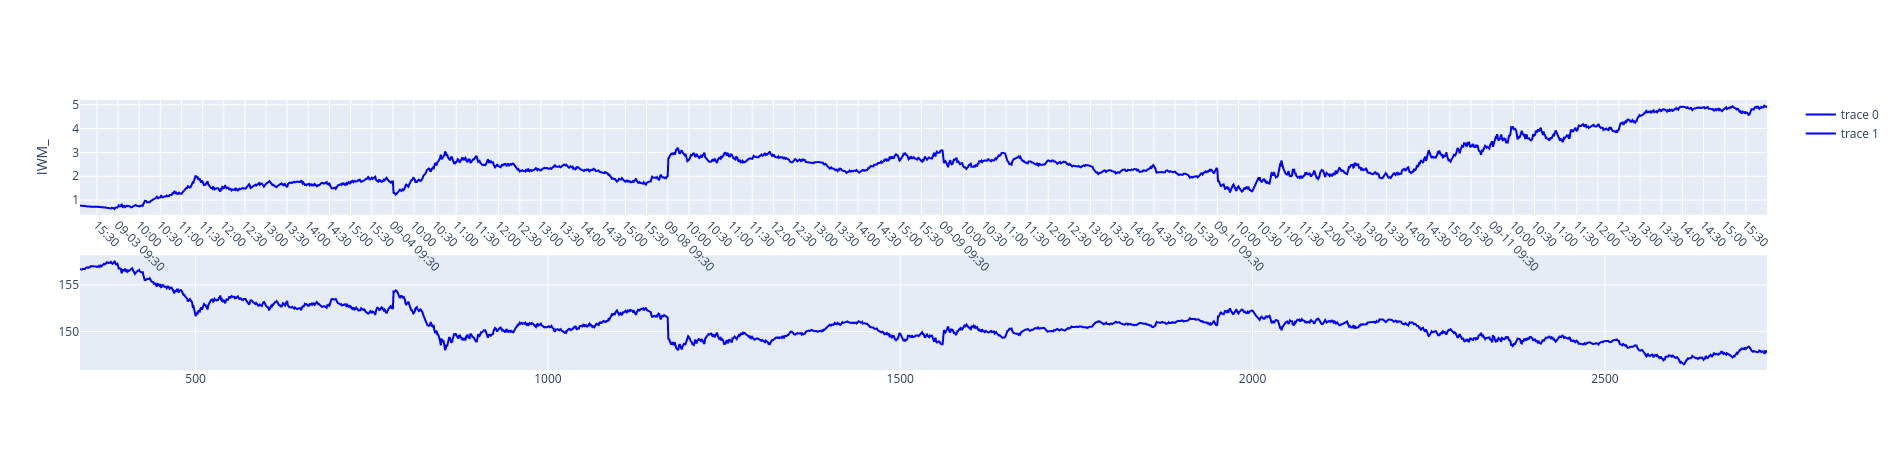

In [32]:

import plotly.graph_objects as go
from plotly.subplots import make_subplots

MARKET_DAY_MINUTES = (6 * 60 + 30)
MARKET_DAY_START = (9 * 60 + 30)
TICK_SPACING = 30

TICK_OFFSET = 0


def show_graphs( dfs ):
    
    fig = make_subplots(rows = len(dfs),cols = 1,shared_xaxes=False)

    hoverdata = []
    
    tickpos = []
    ticktext = []
    indexes = []
    trace = []

    
    for plotnum,dfn in enumerate(dfs):
        
        
        df = dfn.copy()
        
        col_name = df.columns[-1]


        def convert_time_to_minute_index(df,date,day_num):
    
            day_base = day_num * MARKET_DAY_MINUTES 
    
            df_date = df[df['time'].apply(lambda x: x.date() == date)].copy()
    
            df_date['time'] = df_date['time'].apply( lambda x: x.time().hour * 60 + x.time().minute)

            df_date['time'] = df_date['time'] - MARKET_DAY_START + day_base
    
            return list(df_date['time'])

        def get_axis_ticks(date,day_num,offset):
    
            tickpos = []
            ticktext = []
        
            day_base = day_num * MARKET_DAY_MINUTES
        
            day_ticks = [ x for x in range(0,MARKET_DAY_MINUTES)]
        
            for i,day_tick in enumerate(day_ticks):
                if not day_tick % TICK_SPACING:
                    tickpos.append(i + day_base + TICK_OFFSET)
                    day_minute = day_tick + MARKET_DAY_START
                    hour = int(day_minute/60)
                    t = time( hour,day_minute - hour*60)
                    t = datetime.combine(date,t)
                
                    if not i:
                        if not day_num:
                            ticktext.append(t.strftime("%Y-%m-%d %H:%M"))
                        else:
                            ticktext.append(t.strftime("%m-%d %H:%M"))
                    else:
                        ticktext.append(t.strftime("%H:%M"))
                    
            return tickpos,ticktext

        indexes.append([])
        
        tickpos.append([])
        ticktext.append([])
        hoverdata.append([])

        hoverdata[plotnum].append(df['time'].apply(lambda x: x.strftime("%H:%M")))
        

        offset_time = df['time'].iloc[0].time()
        offset = offset_time.hour * 60 + offset_time.minute - MARKET_DAY_START

        dates = df['time'].apply(lambda x: x.date()).unique()
        for i,date in enumerate(dates):
            minute_index = convert_time_to_minute_index(df,date,i)
            indexes[plotnum].extend(minute_index)
            pos,text = get_axis_ticks(date,i,offset)
            tickpos[plotnum].extend(pos.copy())
            ticktext[plotnum].extend(text.copy())
    
        df['time'] = indexes[plotnum]

#        trace = go.Figure(data=[go.Scatter(x=df['time'],y=df['close'],
#                                     #customdata=customdata,
#                                     #hovertemplate='z1:%{customdata[0]:.3f}',
#                                     hovertext = hoverdata,
#                                     hoverlabel=dict(namelength=0),
#                                     hovertemplate='%{hovertext}<br>%{x}<br>%{y:.2f}',
#                                     #mode='lines',  # without mode, defaults to line+markers
#                                     line_color = 'blue')])
        
        trace.append(go.Scatter(x=df['time'],y=df[col_name],
                                     #customdata=customdata,
                                     #hovertemplate='z1:%{customdata[0]:.3f}',
                                     hovertext = hoverdata[plotnum],
                                     hoverlabel=dict(namelength=0),
                                     hovertemplate='%{hovertext[plotnum]}<br>%{x}<br>%{y:.2f}',
                                     #mode='lines',  # without mode, defaults to line+markers
                                     line_color = 'blue'))



#        trace.update_layout(yaxis_title='AAPL Stock',
#                     xaxis = dict(tickangle = 45,
#                                 tickmode = 'array',
#                                  tickvals = tickpos,
#                                 ticktext = ticktext))
        
        fig.append_trace(trace[plotnum],row = plotnum+1,col =1)
        
        sym = df.iloc[0]['symbol']
        
        fig.update_layout(yaxis_title=sym,xaxis = dict(tickangle = 45,
                        tickmode = 'array',
                        tickvals = tickpos[plotnum],
                        ticktext = ticktext[plotnum]))
        
        #trace.show()
        

    fig.show()
    

data = {'time':[datetime(2020,2,3,10,0),
                datetime(2020,2,3,10,15),
                datetime(2020,2,3,11,22),
                datetime(2020,2,3,13,10),
                
                datetime(2020,2,4,9,31),
                datetime(2020,2,4,13,30),
                datetime(2020,2,4,14,24),
                datetime(2020,2,4,16,0),
                
                datetime(2020,2,5,9,31),
                datetime(2020,2,5,11,22),
                datetime(2020,2,5,13,50),
                datetime(2020,2,5,16,00)
               ],
        
        'close':[1,2,3,4,5,6,7,8,9,10,11,12]}

#df = pd.DataFrame(data)

df = trades[200]



show_graphs([df.bars_premium,df.bars_underlying])



In [ ]:
show_graphs([df.bars_underlying])

In [ ]:


data = {'time':[datetime(2020,2,3,9,45),
                datetime(2020,2,3,10,15),
                datetime(2020,2,3,11,22),
                datetime(2020,2,3,13,10),
                datetime(2020,2,4,10,1),
                datetime(2020,2,4,13,30),
                datetime(2020,2,4,14,34),
                datetime(2020,2,4,16,30),
                datetime(2020,2,5,9,31),
                datetime(2020,2,5,11,22),
                datetime(2020,2,5,13,50),
                datetime(2020,2,5,13,30)
               ],
        
        'close':[1,2,3,4,5,6,7,8,9,10,11,12]}

df = pd.DataFrame(data)

In [ ]:
df

In [ ]:
time(4,5)

In [ ]:
datetime.combine

In [ ]:
df = trades[2]
df.bars_premium

In [ ]:
df.bars_underlying

In [ ]:
int_times = np.intersect1d(df.bars_buy.time,df.bars_sell.time)
print(len(int_times))
print(len(df.bars_buy))
print(len(df.bars_sell))

In [ ]:
common_buy = df.bars_buy[df.bars_buy['time'] == int_times]

In [ ]:
commen_sell = df.bars_sell[df.bars_sell['time'] == int_times]

In [ ]:
s1 = pd.merge(df.bars_sell,df.bars_buy, how='inner', on=['time'])
s1.dropna(inplace=True)

In [ ]:
frame = { 'time': s1['time'],'mid': s1['mid_x'] - s1['mid_y']}

In [ ]:
result = pd.DataFrame(frame)

In [ ]:
print(result)

In [ ]:
s1 = pd.merge(df.bars_sell,df.bars_buy, how='inner', on=['time'])
s1.dropna(inplace=True)
frame = { 'time': s1['time'],'mid': s1['mid_x'] - s1['mid_y']}
result = pd.DataFrame(frame)

In [ ]:
trades[2].bars_premium

In [ ]:
trades[3].bars_premium